# 1. Exploratory Data Analysis

## 1.1 Detect and Handling Missing Values

In [555]:
import pandas as pd

df = pd.read_csv('american_bankruptcy_dataset.csv')
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 company_name    0
fyear           0
status_label    0
X1              0
X2              0
X3              0
X4              0
X5              0
X6              0
X7              0
X8              0
X9              0
X10             0
X11             0
X12             0
X13             0
X14             0
X15             0
X16             0
X17             0
X18             0
Division        0
MajorGroup      0
dtype: int64


## 1.2 Distinguish Attributes

| Column | Header                        | Description                                                  |
| ------ | ----------------------------- | ------------------------------------------------------------ |
| X1     | Current assets                | All the assets of a company that are expected to be sold or used as a result of standard business operations over the next year. |
| X2     | Cost of goods sold            | The total amount a company paid as a cost directly related to the sale of products. |
| X3     | Depreciation and amortization | Depreciation refers to the loss of value of a tangible fixed asset over time (such as property. machinery, buildings, and plant). Amortization refers to the loss of value of intangible assets over time. |
| X4     | EBITDA                        | Earnings before interest, taxes, depreciation and amortization: Measure of a company’s overall financial performance alternative to the net income. |
| X5     | Inventory                     | The accounting of items and raw materials that a company either uses in production or sells. |
| X6     | Net Income                    | The overall profitability of a company after all expenses and costs have been deducted from total revenue. |
| X7     | Total Receivables             | The balance of money due to a firm for goods or services delivered or used but not yet paid for by customers. |
| X8     | Market value                  | The price of an asset in a marketplace. In our dataset it refers to the market capitalization since companies are publicly traded in the stock market. |
| X9     | Net sales                     | The sum of a company’s gross sales minus its returns, allowances, and discounts. |
| X10    | Total assets                  | All the assets, or items of value, a business owns.          |
| X11    | Total Long term debt          | A company’s loans and other liabilities that will not become due within one year of the balance sheet date. |
| X12    | EBIT                          | Earnings before interest and taxes.                          |
| X13    | Gross Profit                  | The profit a business makes after subtracting all the costs that are related to manufacturing and selling its products or services. |
| X14    | Total Current Liabilities     | It is the sum of accounts payable, accrued liabilities and taxes such as Bonds payable at the end of the year, salaries and commissions remaining. |
| X15    | Retained Earnings             | The amount of profit a company has left over after paying all its direct costs, indirect costs, income taxes and its dividends to shareholders. |
| X16    | Total Revenue                 | The amount of income that a business has made from all sales before subtracting expenses. It may include interest and dividends from investments. |
| X17    | Total Liabilities             | The combined debts and obligations that the company owes to outside parties. |
| X18    | Total Operating Expenses      | The expense a business incurs through its normal business operations |


In [559]:
# Map alive to 0, failed to 1 in clolumn status_label

df['status_label'] = df['status_label'].map({'alive': 0, 'failed': 1})
print(df['status_label'])

0        0
1        0
2        0
3        0
4        0
        ..
78677    0
78678    0
78679    0
78680    0
78681    0
Name: status_label, Length: 78682, dtype: int64


## 1.3 Apply Benford's Law

In [524]:
def get_company_numeric_data(c_name):
    '''
    Get all numeric data of a selected company
    '''
    
    # Filter the data of the specified company based on company_name
    company_data = df[df['company_name'] == c_name]

    # Extract data from columns X1 to X18
    company_numeric_data = company_data.loc[:, 'X1':'X18'].values.flatten().tolist()

    return(company_numeric_data)

In [526]:
from collections import Counter

def frequency_of_first_digit(list):
    '''
    Calculate the frequency of the first digit
    '''
    # Get the first digit of the absolute value of all numbers
    first_digits = [int(str(abs(x))[0]) for x in list]

    # Count the number of occurrences of each first digit
    counter = Counter(first_digits)

    # Calculate the frequency of each number
    total_count = sum(counter.values())
    frequency = [counter.get(digit, 0) for digit in range(1, 10)]

    # print(frequency)

    return frequency

In [528]:
from scipy.stats import ks_2samp

def kolmogorov_smirnov_test(fre, theo_fre):
    '''
    Kolmogorov–Smirnov test
    '''
    statistic, p_value = ks_2samp(fre, theo_fre)

    return p_value

In [530]:
from scipy.stats import chisquare

def chi_square_test(observed, expected):
    # normalization
    observed = [x / sum(observed) for x in observed]
    
    chi2_stat, p_value = chisquare(f_obs=observed, f_exp=expected)

    # print(f"Chi-Square Statistic: {chi2_stat}")
    # print(f"P-Value: {p_value}")

    return p_value

In [532]:
import math

# calculate theoretical frequency

theoretical_frequency = [math.log10(1+1/digit) for digit in range(1, 10)]

print(theoretical_frequency)

[0.3010299956639812, 0.17609125905568124, 0.12493873660829993, 0.09691001300805642, 0.07918124604762482, 0.06694678963061322, 0.05799194697768673, 0.05115252244738129, 0.04575749056067514]


In [540]:
# count = 0
# for i in range(1, 8972):
#     c_name = 'C_'+str(i)
#     # print(c_name)
#     list = get_company_numeric_data(c_name)
#     fre = frequency_of_first_digit(list)
#     p_value = chi_square_test(fre, theoretical_frequency)
#     if p_value < 0.05:
#         count+=1
# print('Detected bankruptcy:', count)

We found that Benford's Law has no obvious effect on bankruptcy detection.

## 1.4 Univariate Analysis

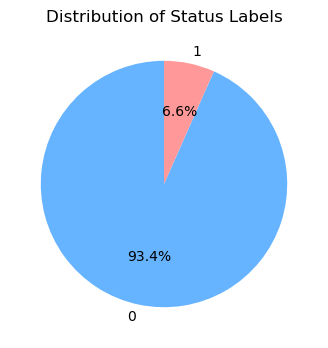

In [544]:
import matplotlib.pyplot as plt

# Count the occurrences of each unique value
status_counts = df['status_label'].value_counts()

# Create a pie chart to show the ratio of alive and failed
plt.figure(figsize=(4, 4))
plt.pie(
    status_counts,
    labels=status_counts.index,
    autopct='%1.1f%%',  # Display percentages
    startangle=90,      # Start pie chart at 90 degrees
    colors=['#66b3ff', '#ff9999']  # Custom colors
)

plt.title('Distribution of Status Labels')
plt.show()

According to pie chart, we can clearly find out this is an imbalance dataset. So we need to handle this problem with **sampling**. 

## 1.5 Multi-variate Analysis

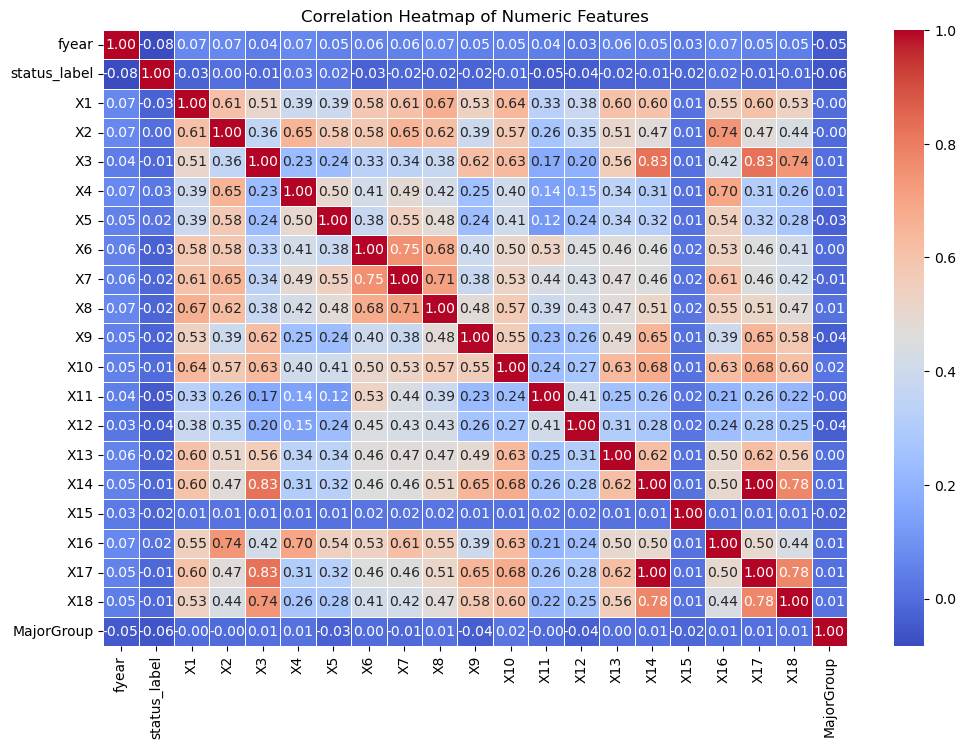

In [548]:
import seaborn as sns

# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

## 1.6 Feature Engineering

In [561]:
# Delete column company_name, fyear, MajorGroup
df = df.drop(columns=['company_name', 'fyear', 'MajorGroup'])

print(df.head())

   status_label        X1          X2        X3        X4        X5        X6  \
0             0  511267.0  740998.000  833107.0  180447.0  18373.00  70658.00   
1             0  485856.0     701.854  713811.0  179987.0  18577.00     45.79   
2             0  436656.0  710199.000  526477.0  217699.0  22496.00   4711.00   
3             0  396412.0     686.621  496747.0  164658.0  27172.00   3573.00   
4             0  432204.0     709.292  523302.0  248666.0     26.68  20811.00   

          X7         X8          X9       X10        X11         X12  \
0  89031.000  191226.00     336.018  163816.0     35.163  201026.000   
1  64367.000  160444.00     320.590  125392.0  18531.000  204065.000   
2  27207.000  112244.00  286588.000  150464.0    -58.939     139.603   
3  30745.000     109.59  259954.000  203575.0    -12.410  124106.000   
4     47.491  128656.00  247245.000  131261.0   3504.000  131884.000   

          X13          X14       X15       X16          X17       X18 Division  

In [595]:
from sklearn.preprocessing import LabelEncoder

# Convert the specified column(status_label, Division) to categorical encoding
label_encoders = {}
for col in ['status_label', 'Division']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Save encoder for decoding

# Output the encoded data
print("\nEncoded data:")
print(df.tail())


Encoded data:
       status_label        X1          X2       X3          X4         X5  \
78677             0  233211.0  1099101.00  43338.0  184666.000  14094.000   
78678             0  105559.0  1865926.00  59184.0     770.103  42592.000   
78679             0   63971.0  1746235.00  69074.0  683985.000  65057.000   
78680             0  135207.0     1736.11  66527.0  694035.000     65.330   
78681             0   82589.0     1625.37  68817.0  632122.000     65.201   

               X6        X7        X8        X9        X10         X11  \
78677   31521.000   45615.0   60885.0     3.376  28197.000   25261.000   
78678  159541.000  202133.0  231969.0     2.288     88.128  129688.000   
78679      13.994   79051.0  100784.0     2.581  85765.000   -1442.000   
78680    3841.000   69171.0   95357.0  2013.000     82.010  -20401.000   
78681    2061.000   67262.0   91696.0  2112.000  79365.000     -50.946   

            X12      X13       X14          X15         X16       X17  \
7867

In [597]:
# Feature Engineering based on Feature Correlation
# TODO

# 2. Prepare Datasets

## 2.1 Split Datasets by alive and failed ratio 

In [587]:
from sklearn.model_selection import train_test_split

# Split datasets based on the ratio of alive and failed
X = df.drop('status_label', axis=1)
y = df['status_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Size and ratio of training and testing datasets
print("Training set size:", X_train.shape)
print("\nTest set size:", X_test.shape)
print("\nTraining set:")
print(y_train.value_counts(normalize=True))
print("\nTesting set:")
print(y_test.value_counts(normalize=True))

Training set size: (62945, 19)

Test set size: (15737, 19)

Training set:
status_label
0    0.933656
1    0.066344
Name: proportion, dtype: float64

Testing set:
status_label
0    0.93366
1    0.06634
Name: proportion, dtype: float64


## 2.2 Handling Imbalance Datasets

Faced with imbalance datasets, we use SMOTE to oversampling. We will generate new minority class samples through interpolation.

In [604]:
from imblearn.over_sampling import SMOTE

# Oversampling by SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Training set size:", X_resampled.shape)
print("\nTesting set after oversampling:")
print(pd.Series(y_resampled).value_counts())

Training set size: (117538, 19)

Testing set after oversampling:
status_label
0    58769
1    58769
Name: count, dtype: int64


# 3. Train and Test Datasets 

In [606]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Model training
clf = RandomForestClassifier(random_state=42)
clf.fit(X_resampled, y_resampled)

# Predict on testing set
y_pred = clf.predict(X_test)

# Model evaluation
print("\nClassification report:")
print(classification_report(y_test, y_pred))

print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_pred))


Classification report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     14693
           1       0.22      0.23      0.22      1044

    accuracy                           0.89     15737
   macro avg       0.58      0.58      0.58     15737
weighted avg       0.90      0.89      0.90     15737


Confusion matrix:
[[13837   856]
 [  809   235]]
